In [ ]:
!pip install torch==1.8.1+cpu -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 169.1 MB 141 kB/s 
ERROR: torchvision 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.8.1+cpu which is incompatible.
  Attempting uninstall: torch
    Found existing installation: torch 1.8.0
    Not uninstalling torch at /shared-libs/python3.7/py/lib/python3.7/site-packages, outside environment /root/venv
    Can't uninstall 'torch'. No files were found to uninstall.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
import os
import gc
import warnings
import IPython

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import neptune.new as neptune

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder, StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset, DataLoader

NEPTUNE_API_TOKEN = os.environ["NEPTUNE_API_TOKEN"]
plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")

In [ ]:
def display(*dfs):
    for df in dfs:
        IPython.display.display(df)

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def preprocess_datetime(df, time_columns):
    for t in time_columns:
        df[t+'_month'] = df[t].dt.month
        df[t+'_is_month_start'] = df[t].dt.is_month_start.astype('int')
        df[t+'_is_month_end'] = df[t].dt.is_month_end.astype('int')
        df[t+'_day'] = df[t].dt.day
        df[t+'_hour'] = df[t].dt.hour
        df[t+'_dayofweek'] = df[t].dt.dayofweek
        df[t+'_is_weekend'] = (df[t+'_dayofweek'] >= 5).astype('int')
        df[t+'_quarter'] = df[t].dt.quarter


def replace_na_on_missing(x): return np.where(x.isna(), 'missing', x)

In [ ]:
EPSILON = 1e-38

def _error(actual: np.ndarray, predicted: np.ndarray):
    """ Simple error """
    return actual - predicted


def _percentage_error(actual: np.ndarray, predicted: np.ndarray):
    """
    Percentage error
    Note: result is NOT multiplied by 100
    """
    return _error(actual, predicted) / (actual + EPSILON)


def mdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Median Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.median(np.abs(_percentage_error(actual, predicted)))

In [ ]:
def get_submittion(preds, df_test):
    submittion = df_test[['transaction_id']]
    submittion['price'] = preds
    submittion.to_csv('submittion.csv', index=False)


def get_data():
    df_2017 = pd.read_csv('data/2017.csv')
    df_2018 = pd.read_csv('data/2018.csv')
    df_test = pd.read_csv('data/2019.csv')
    print(df_2017.shape, df_2018.shape, df_test.shape)

    df_ini = pd.concat([df_2017, df_2018])
    assert df_2017.shape[0] + df_2018.shape[0] == df_ini.shape[0]

    df_ini = reduce_mem_usage(df_ini)
    df_test = reduce_mem_usage(df_test)
    return  df_ini, df_test, #df


def preprocess_main(df):
    df['created'] = pd.to_datetime(df.created)
    preprocess_datetime(df, ['created'])
    features_objects = df.select_dtypes('object').columns
    features_cat = [f for f in features_objects \
                    if f not in features_str + features_address + ['transaction_id']]
    df[features_cat] = df[features_cat].astype('category')
    df[features_str] = df[features_str].astype('string')

    df.drop(TO_DROP, axis=1, inplace=True)
    current_to_drop = ['created_month', 'created_quarter', 'created_hour']
    df.drop(current_to_drop, axis=1, inplace=True)
    
    features_num = df.select_dtypes(include=['float16', 'float32', 'int32', 'int64']).columns
    assert len(features_cat) + len(features_str) + len(features_address)\
        + len(features_num) ==  df.shape[1] # - 2 # transaction_id, created
#     features_withna = df.drop(features_str + features_address, axis=1).columns
    
    return features_cat, features_num


def categorical_to_numerical_features(df, df_test, features_cat):
    train_size = df.shape[0]
    data = pd.concat([df, df_test], axis=0)[features_cat]
    data[features_cat] = data[features_cat].apply(replace_na_on_missing).astype('category')
    # cat2num = data[features_cat].cat.categories
    data[features_cat] = data[features_cat].apply(lambda x: x.cat.codes.astype('category'))

    return data.iloc[:train_size], data.iloc[train_size:]    

In [ ]:
df_ini, df_test = get_data()
np.random.seed(2021)
idx = np.random.choice(np.arange(0, df_ini.shape[0]),
                                size=100_000, replace=False)
df = df_ini.iloc[idx]

(992212, 43) (986565, 43) (28323, 42)
Mem. usage decreased to 471.78 Mb (29.0% reduction)
Mem. usage decreased to  6.43 Mb (29.2% reduction)


In [ ]:
features_str = ['epc_windows_description',
                'epc_walls_description',
                'epc_roof_description',
                ]
features_address = ['street', 
                    'city', 
                'building_number', 'flat',
                'building_name',
                'postcode_sector',
                'postcode']
TO_DROP = ['transaction_id', 'created', 'address_id']


def preprocess_total(df, df_test):
    df, df_test = df.copy(), df_test.copy()
    features_cat, features_num = preprocess_main(df)
    _ = preprocess_main(df_test)
    df_test['price'] = np.nan

    # nans
    df[features_cat], df_test[features_cat] = categorical_to_numerical_features(df, df_test,
                                                                           features_cat)
    # train_size = df.shape[0]
    # data = pd.concat([df, df_test], axis=0)[features_cat]
    # data[features_cat] = data[features_cat].apply(replace_na_on_missing).astype('category')
    # ohe = pd.get_dummies(data[features_cat], drop_first=True)
    # print(ohe.shape)
    # df = pd.concat([df, ohe.iloc[:train_size]], axis=1)
    # df_test = pd.concat([df_test, ohe.iloc[train_size:]], axis=1)
    # df.drop(features_cat,axis=1, inplace=True)
    # df_test.drop(features_cat,axis=1, inplace=True)

    df[features_num] = df[features_num].fillna(0)
    # check nans exist only in unused features
    if df.loc[:, df.isna().sum() != 0]\
                .select_dtypes(exclude=['object', 'string']).shape[1] != 0:
                print('There are nans in data')


    cv_folds = TimeSeriesSplit(n_splits=5)
    cv_idx = list(cv_folds.split(df, df.price))[-1]
    train = df.iloc[cv_idx[0]]
    val = df.iloc[cv_idx[1]]

    f_all = train.drop(['price'], axis=1).select_dtypes(exclude=['object', 'string']).columns
    # display(train[f_all].dtypes)
    ss = StandardScaler().fit(train[f_all])
    train[f_all] = ss.transform(train[f_all])
    val[f_all] = ss.transform(val[f_all])
    df_test[f_all] = ss.transform(df_test[f_all])
    
    return train, val, df_test, features_cat


train, val, test, features_cat = preprocess_total(df, df_test)
features = features_str + features_address #+ ['price']
train.drop(features, axis=1, inplace=True)
val.drop(features, axis=1, inplace=True)
test.drop(features, axis=1, inplace=True)

In [ ]:
class ShelterOutcomeDataset(Dataset):
    def __init__(self, df):
        self.X = df.drop(columns='price').copy().values.astype(np.float32) 
        self.y = df.price.values.reshape(-1,1).copy().astype(np.float32)
        print(self.X.shape, self.y.shape)

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

    
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        print('__ device cuda')
        return torch.device('cuda')
    else:
        print('__ device cpu')
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
class NNModel(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super().__init__()
        self.input_size = input_size
        self.hidden_sizes  = hidden_sizes
        # self.bn1 = nn.BatchNorm1d(self.input_size)

        self.fc1 = nn.Linear(self.input_size, self.hidden_sizes[0])  
        # self.drops = nn.Dropout(0.3)
        # self.bn2 = nn.BatchNorm1d(self.hidden_sizes[0])
        
        self.fc2 = nn.Linear(self.hidden_sizes[0], self.hidden_sizes[1])
        # self.bn3 = nn.BatchNorm1d(self.hidden_sizes[1])
        
        self.fc3 = nn.Linear(self.hidden_sizes[1], 1)

    def forward(self, x):
        # x = self.bn1(x)

        x = F.relu(self.fc1(x))
        # x = self.drops(x)
        # x = self.bn2(x)
        
        x = F.relu(self.fc2(x))
        # x = self.drops(x)
        # x = self.bn3(x)

        x = self.fc3(x)
        return x


def train_eval_model(model, criterion, optimizer=None, dl=None):
    n, loss_sum = 0, 0
    n_mdape, loss_mdape_sum = 0, 0
    
    for x, y in dl:
        batch = y.shape[0]
        output = model(x)
        loss = criterion(output, y)
        if optimizer is not None:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        n += batch
        loss_sum += batch*(loss.item())
        
        with torch.no_grad():
            loss_mdape = mdape(y.cpu(), output.cpu())
            n_mdape += batch
            loss_mdape_sum += batch*(loss_mdape.item())
        
    return loss_sum/n, loss_mdape_sum/n_mdape


def get_prediction(data, model, flag_plot=False):
    dl = get_dataloader(data, params_neptune['batch_size'], 
                        device='cpu', flag_train=False)
    preds = []
    with torch.no_grad():
        for x, y in dl:
            out = model(x)
            preds.append(out)
    preds = pd.Series([item.item() for sublist in preds for item in sublist])
    if data.price.notna().all():
        print(mdape(data.price.values, preds))
    if flag_plot:
        fig, axes = plt.subplots(1,2, figsize=(10,5))
        temp = pd.concat([preds, val[['price']].reset_index(drop=True)], axis=1)
        temp.columns = ['pred', 'true']
        temp.plot.scatter(x='true', y='pred', ax=axes[0])
        axes[0].set_title('All data')
        sns.regplot(x='true', y='pred', data=temp[temp.true <= 1e6], 
                    line_kws={'color':'black', 'label': 'regression'}, ax=axes[1])
        plt.plot([0, 1e6], [0,1e6], color='black',linestyle='dashed', label='exact pred')
        axes[1].legend()
        axes[1].set_title('Data with price < 1e6')
        return preds, fig
    return preds


def train_loop(model, train_dl, valid_dl, params_neptune,
                optimezer, flag_neptune=False, flag_val=True):

    criterion = nn.L1Loss()
    val_mdapes = []
    if flag_val: to_end = ' | '
    else: to_end='\n'
    print('\ttrain\t\t\tval')
    print('\tloss\tmdape\t\tloss\tmdape')

    if flag_neptune:
        run = neptune.init(project='declot/Enbysis-UK-Rental', 
                            api_token=NEPTUNE_API_TOKEN,
                            source_files=['2_NN.ipynb', 'requirements.txt'])
        run['parameters'] = params_neptune
        run["sys/tags"].add(['NN'])
        run['model'] = model
        
    for i in range(params_neptune['iterations']): 
        model.train()
        t_loss = train_eval_model(model, criterion, optimizer, train_dl)
        print(f'({i:>3}) {t_loss[0]:.2e}\t{t_loss[1]:>.4e}', end=to_end)
        if flag_val:
            model.eval()
            v_loss = train_eval_model(model, criterion, optimizer=None, dl=valid_dl)
            val_mdapes.append(v_loss[1])
        
            print(f'{v_loss[0]:.2e}\t{v_loss[1]:>.4e}')
            if flag_neptune:
                run['loss/train'].log(t_loss[0])
                run['mdape/train'].log(t_loss[1])
                run['loss/val'].log(v_loss[0])
                run['mdape/val'].log(v_loss[1])
                run['cv/mdape_iter'] = np.argmin(val_mdapes) + 1 
            
    preds, fig = get_prediction(val, model, True)
    if flag_neptune: 
        run['pred_true'].upload(fig)
        run['val/mdape'] = mdape(val.price.values, preds)
        run.stop()

NameError: name 'nn' is not defined

In [ ]:
def get_dataloader(data, batch_size, device, flag_train=True):
    data_ds = ShelterOutcomeDataset(data)
    data_dl = DataLoader(data_ds, batch_size=batch_size, shuffle=flag_train)
    data_dl = DeviceDataLoader(data_dl, device)
    return data_dl 


def model_NN(train, val, model, params_neptune, 
                 optimizer, flag_neptune=False):
    device = get_default_device()
    train_dl = get_dataloader(train, params_neptune['batch_size'], device)
    valid_dl = get_dataloader(val, params_neptune['batch_size'], device)
                            
    to_device(model, device)

    train_loop(model, train_dl, valid_dl, params_neptune, 
                optimizer, flag_neptune=flag_neptune)
    return model

In [ ]:
train.shape

(83334, 35)

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)


__ device cpu
(83334, 34) (83334, 1)
(16666, 34) (16666, 1)
	train			val
	loss	mdape		loss	mdape
psutil is not installed. Hardware metrics will not be collected.
https://app.neptune.ai/declot/Enbysis-UK-Rental/e/EN-65
(  0) 2.25e+05	5.0269e-01 | 1.81e+05	3.5269e-01
(  1) 1.84e+05	3.5093e-01 | 1.78e+05	3.5355e-01
(  2) 1.82e+05	3.4382e-01 | 1.77e+05	3.4722e-01
(  3) 1.80e+05	3.3606e-01 | 1.75e+05	3.3407e-01
(  4) 1.79e+05	3.2922e-01 | 1.74e+05	3.2907e-01
(  5) 1.78e+05	3.2478e-01 | 1.73e+05	3.2649e-01
(  6) 1.77e+05	3.2157e-01 | 1.72e+05	3.2291e-01
(  7) 1.77e+05	3.1906e-01 | 1.72e+05	3.2223e-01
(  8) 1.76e+05	3.1827e-01 | 1.71e+05	3.1887e-01
(  9) 1.76e+05	3.1691e-01 | 1.71e+05	3.1984e-01
( 10) 1.76e+05	3.1552e-01 | 1.71e+05	3.1887e-01
( 11) 1.75e+05	3.1393e-01 | 1.71e+05	3.1900e-01
( 12) 1.75e+05	3.1349e-01 | 1.70e+05	3.1519e-01
( 13) 1.75e+05	3.1331e-01 | 1.70e+05	3.1615e-01
( 14) 1.75e+05	3.1111e-01 | 1.70e+05	3.1425e-01
( 15) 1.74e+05	3.1011e-01 | 1.70e+05	3.1724e-01
( 16) 1.74e+05

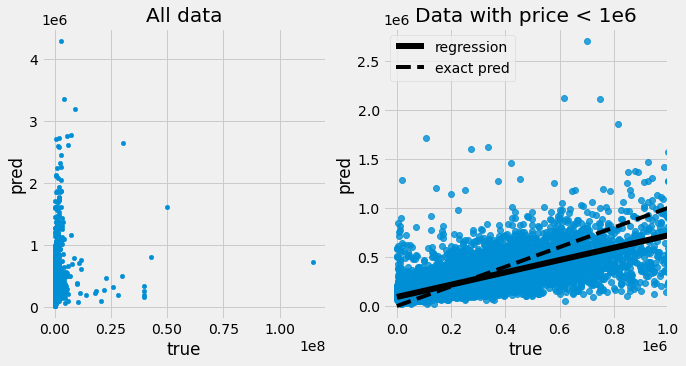

In [ ]:
%%time
input_size = train.shape[1] - 1 #price
params_neptune = dict(loss_function = 'MAE',
                      iterations = 100,
                      batch_size = 264,
                      learning_rate = 0.01, #0.05,
                      l2_reg=0.0001,
                      n_features = input_size
             )

model = nn.Sequential(
          nn.Linear(input_size, 256),
          nn.ReLU(),
          # nn.BatchNorm1d(256),

          nn.Linear(256, 128),
          nn.ReLU(),
          # nn.BatchNorm1d(128),

          nn.Linear(128, 1),
        )
        # self.bn1 = nn.BatchNorm1d(self.input_size)
        # x = F.relu(self.fc1(x))
        # x = self.drops(x)
        # x = self.bn2(x)
model.apply(init_weights)

# model = NNModel(input_size, (64,32))
optimizer = optim.Adam(model.parameters(), 
                       lr=params_neptune['learning_rate'],
                        #    weight_decay=params_neptune['l2_reg'])
    )
m = model_NN(train, val, model, params_neptune=params_neptune, 
            optimizer=optimizer, flag_neptune=True)

In [ ]:
model.apply(init_weights)
test_dl = get_dataloader(test, batch_size=params_neptune['batch_size'],
                        device='cpu:0', flag_train=False)
data  = pd.concat([train, val], axis=0)
data_dl = get_dataloader(data, batch_size=params_neptune['batch_size'],
                        device='cpu:0', flag_train=True)

train_loop(model, data_dl, None, params_neptune, optimizer,
            flag_neptune=False, flag_val=False)

(28323, 34) (28323, 1)
(100000, 34) (100000, 1)
	train			val
	loss	mdape		loss	mdape
Error occurred during asynchronous operation processing: Invalid point for string series: monitoring/stdout : Text longer than 1000 characters was truncated
(  0) 2.00e+05	4.1605e-01
(  1) 1.78e+05	3.2691e-01
(  2) 1.76e+05	3.2072e-01
(  3) 1.75e+05	3.1683e-01
(  4) 1.74e+05	3.1327e-01
(  5) 1.74e+05	3.1157e-01
(  6) 1.73e+05	3.0894e-01
(  7) 1.73e+05	3.0669e-01
(  8) 1.73e+05	3.0518e-01
(  9) 1.72e+05	3.0244e-01
( 10) 1.72e+05	3.0116e-01
( 11) 1.72e+05	3.0008e-01
( 12) 1.71e+05	2.9881e-01
( 13) 1.71e+05	2.9586e-01
( 14) 1.71e+05	2.9307e-01
( 15) 1.70e+05	2.9042e-01
( 16) 1.68e+05	2.8482e-01
( 17) 1.64e+05	2.7341e-01
( 18) 1.59e+05	2.5742e-01
( 19) 1.56e+05	2.4785e-01
( 20) 1.55e+05	2.4428e-01
( 21) 1.54e+05	2.4176e-01
( 22) 1.53e+05	2.3877e-01
( 23) 1.52e+05	2.3756e-01
( 24) 1.52e+05	2.3463e-01
( 25) 1.51e+05	2.3223e-01
( 26) 1.51e+05	2.3111e-01
( 27) 1.50e+05	2.3007e-01
( 28) 1.50e+05	2.2818e-01
( 29

In [ ]:
preds = get_prediction(test, model)
get_submittion(preds, df_test)

(28323, 34) (28323, 1)


### Preprocee text features to categorical

In [ ]:
# def find_by_template_and_replace(temp, df, f, name=''):
#     print(f'''rel. % of samples with cyfartalog: \
# {df[f].dropna().str.extract(tmp).notna().sum()/df.shape[0]*100}''')
#     df[name] = df[f].str.extract(tmp).apply(lambda x: np.where(x.isna(), np.nan,x) )
#     display(df[name].dropna().unique())
#     df[name] = df[name].astype('float')
#     df[f] = df[f].str.replace(tmp, '')

In [ ]:
# f = 'epc_walls_description'

# tmp = '\|Trawsyriannedd thermol cyfartalog =*\s*(\d.*\d*) W/m.*K'
# find_by_template_and_replace(tmp, df, f, 'wall_cyfartalog')
# tmp = 'transmittance =*\s*(\d.*\d*) W/m.*K'
# find_by_template_and_replace(tmp, df, f, 'wall_transmittance')

In [ ]:
# temp = df[f].str.replace('+', ',').str.replace('.', ',').str.replace(', ',',')\
#             .str.split(',', expand=True)
# print(f'% of nan is each col\n{temp.notna().sum(axis=0)/temp.shape[0]*100}')
# temp = temp.iloc[:,:7].apply(replace_na_on_missing).astype('category')
# temp.columns = f + temp.columns.astype('string')
# df = pd.concat((df, temp), axis=1)
# features_cat.extend(temp.columns)
# gc.collect();

In [ ]:
# f = 'epc_roof_description'
# tmp = '(\d+)\+*\s*mm loft '
# find_by_template_and_replace(temp, df, f, 'roof_loft')
# tmp = '\|Trawsyriannedd thermol cyfartalog \d.\d\d'
# df[f] = df[f].str.replace(tmp, '')
# tmp = 'transmittance =*\s*(\d\.*\d*) W/m.*K'
# find_by_template_and_replace(temp, df, f, 'roof_transmittance')


In [ ]:
# temp = df[f].str.replace('+', ',').str.replace('.', ',').str.replace(', ',',')\
#             .str.split(',', expand=True)
# print(f'% of nan is each col\n{temp.notna().sum(axis=0)/temp.shape[0]*100}')
# temp = temp.iloc[:,:5].apply(replace_na_on_missing).astype('category')
# temp.columns = f + temp.columns.astype('string')
# df = pd.concat((df, temp), axis=1)
# features_cat.extend(temp.columns)
# gc.collect();

In [ ]:
# f = 'epc_windows_description'
# df[f] = df[[f]].apply(replace_na_on_missing).values
# features_cat.append(f)
# # features_str.remove(f)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e0716c79-cd49-421b-b62e-acc802240d39' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>